In [99]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [100]:
from fastai import *
from fastai.text import *

In [101]:
import sklearn.feature_extraction.text as sklearn_text

Set path, batchsize, path etc

In [102]:
path = Path('/users/rknol/Downloads/data_models/superawesome')

In [103]:
bs=128

In [104]:
lang = 'nl'

In [105]:
lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']

Load in data, including the wiki model that I trained in the NLWiki notebook

In [106]:
df = pd.read_csv(path/'cleaned.csv',sep=';')

In [108]:
data_lm = data_clas = (TextList.from_df(df, path, vocab=data_lm.vocab, cols='Message')
    .split_by_rand_pct(0.1, seed=40)
    .label_for_lm() 
    .databunch(bs=bs, num_workers=1))

In [109]:
data_clas = TextClasDataBunch.from_csv(path, 'cleaned.csv', vocab=data_lm.train_ds.vocab, bs=32, delimiter=';')

In [121]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0)

Training using the NLWiki model

In [122]:
lr = 1e-3
lr *= 128/48

In [123]:
learn_lm.fit_one_cycle(4, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.564491,5.279211,0.179762,08:51
1,5.448371,4.398786,0.297024,08:44
2,4.937840,4.297078,0.309524,08:37
3,4.666825,4.283634,0.310900,08:35


Now unfreezing and training some more

In [132]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(4, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.278755,4.201849,0.319568,26:33
1,4.198774,4.114336,0.324144,26:55
2,4.130535,4.084127,0.329502,27:02
3,4.083386,4.077861,0.330208,28:35


xxbos is start of line, data has a lot of short messages. The dutch sentences are reasonably grammatically correct, often include English video game phrases

In [136]:
learn_lm.predict("Wat", 30)

'Wat een minimum is uit 4 bent leuke kleine bereiken xxbos Echt na andere islands heeft ik wel een leeftijd over anderhalf uur op het scherm gewerkt xxbos Ik'

In [137]:
learn_lm.save(f'{lang}fine_tuned')
learn_lm.save_encoder(f'{lang}fine_tuned_enc')

CLASSIFIER

In [138]:
data_clas = (TextList.from_df(df, path, vocab=data_lm.vocab, cols='Message')
    .split_by_rand_pct(0.1, seed=40)
    .label_from_df(cols='Name')
    .databunch(bs=bs, num_workers=1))

data_clas.save(f'{lang}_textlist_class')

In [139]:
data_clas = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=1)

In [140]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(f'{lang}fine_tuned_enc')
learn.freeze()

In [141]:
lr=2e-2
lr *= bs/48

In [142]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.077743,2.358936,0.465482,14:31
1,0.796104,1.594377,0.465482,18:35


In [83]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.874913,0.272250,0.745703,03:16
1,0.639378,0.383535,0.745703,03:16


In [87]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.359080,0.230014,0.745703,11:17
1,0.482056,0.238537,0.745703,11:13


In [ ]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

In [ ]:
learn.save('whatsapp_full')

I removed most of my analysis as to not include personal information

In [143]:
interp = ClassificationInterpretation.from_learner(learn_c)

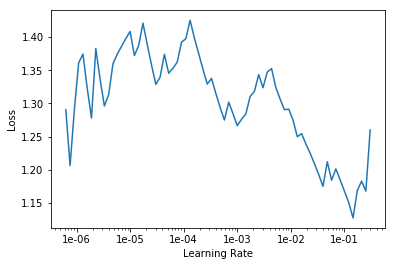

In [63]:
learn_c.recorder.plot()